In [1133]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [1134]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [1135]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [1136]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [1137]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [1138]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], train0_df.shape[0], 2  , None )
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], train0_df.shape[0], 2  , model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], test0_df.shape[0], 2  , model_stats_df )

model_stats_df = model_results('Naive_train', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , model_stats_df )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

model_stats_df

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (200, 20)
test_df:  (50, 20)


,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,-1.1459,-1.1568,25.0445,5.0044
1,ffef_tr_test,-40.4673,-41.3312,56.7392,7.5325
2,ffef_tr2_train,0.9079,0.9074,1.0753,1.0369
3,ffef_tr2_test,0.7806,0.7760,0.3002,0.5479
4,Naive_train,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002


model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

# Load Data

In [1139]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE < "2007-09-30"')
train_df, test_df = time_split(taylor_df)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
train_df:  (200, 20)
test_df:  (50, 20)


In [1140]:
taylor_df['chair_name'].unique()

array(['Martin', 'Burns', 'Miller', 'Volcker', 'Greenspan', 'Bernanke',
       'Yellen', 'Powell'], dtype=object)

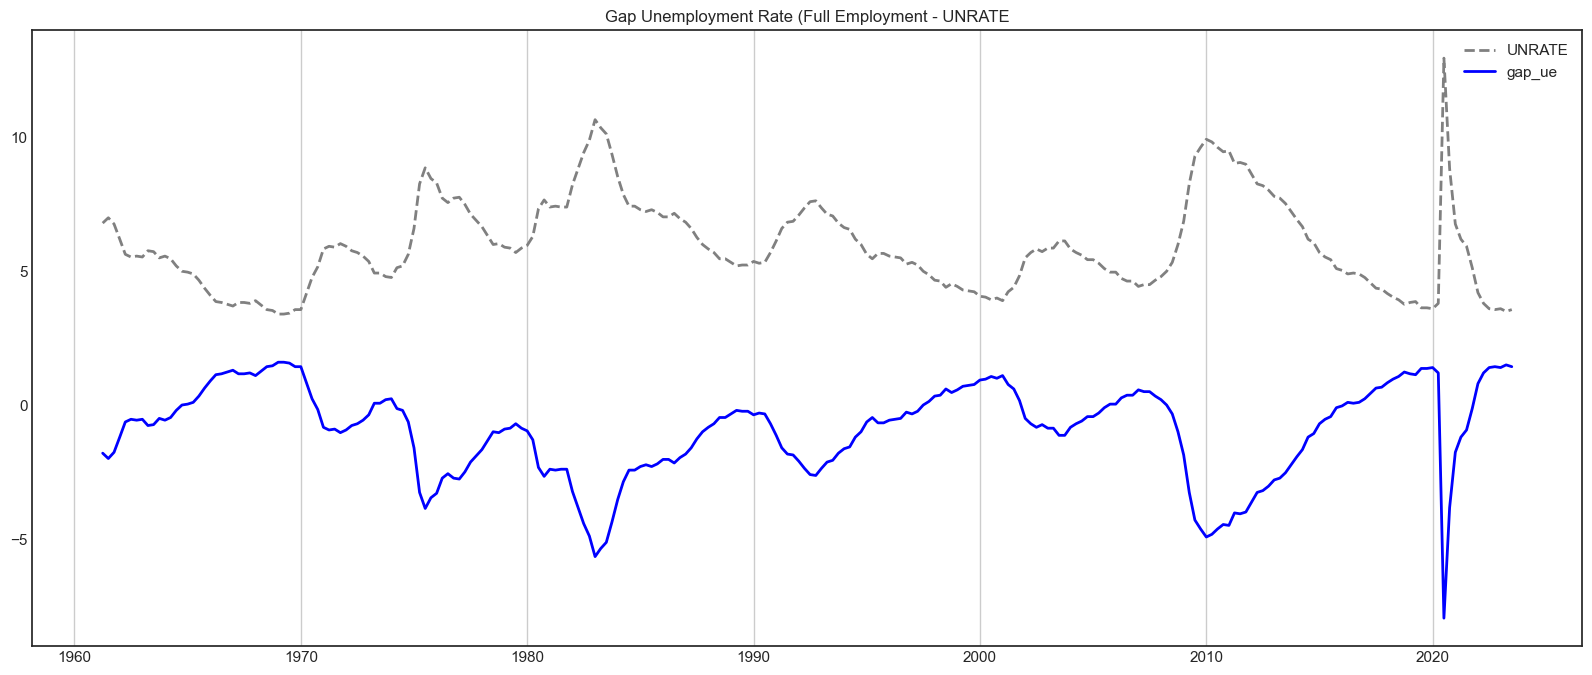

In [1141]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

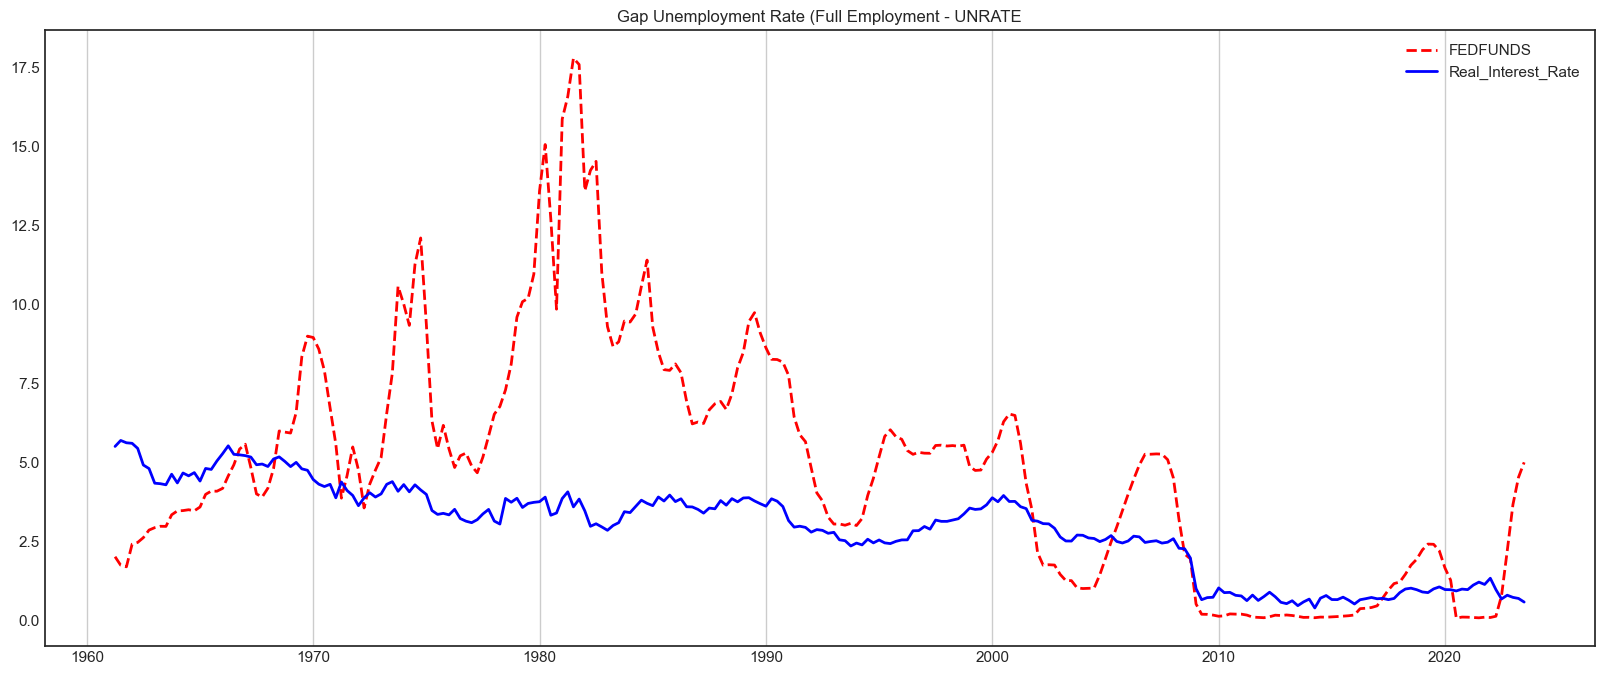

In [1142]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'red', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS","Real_Interest_Rate"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

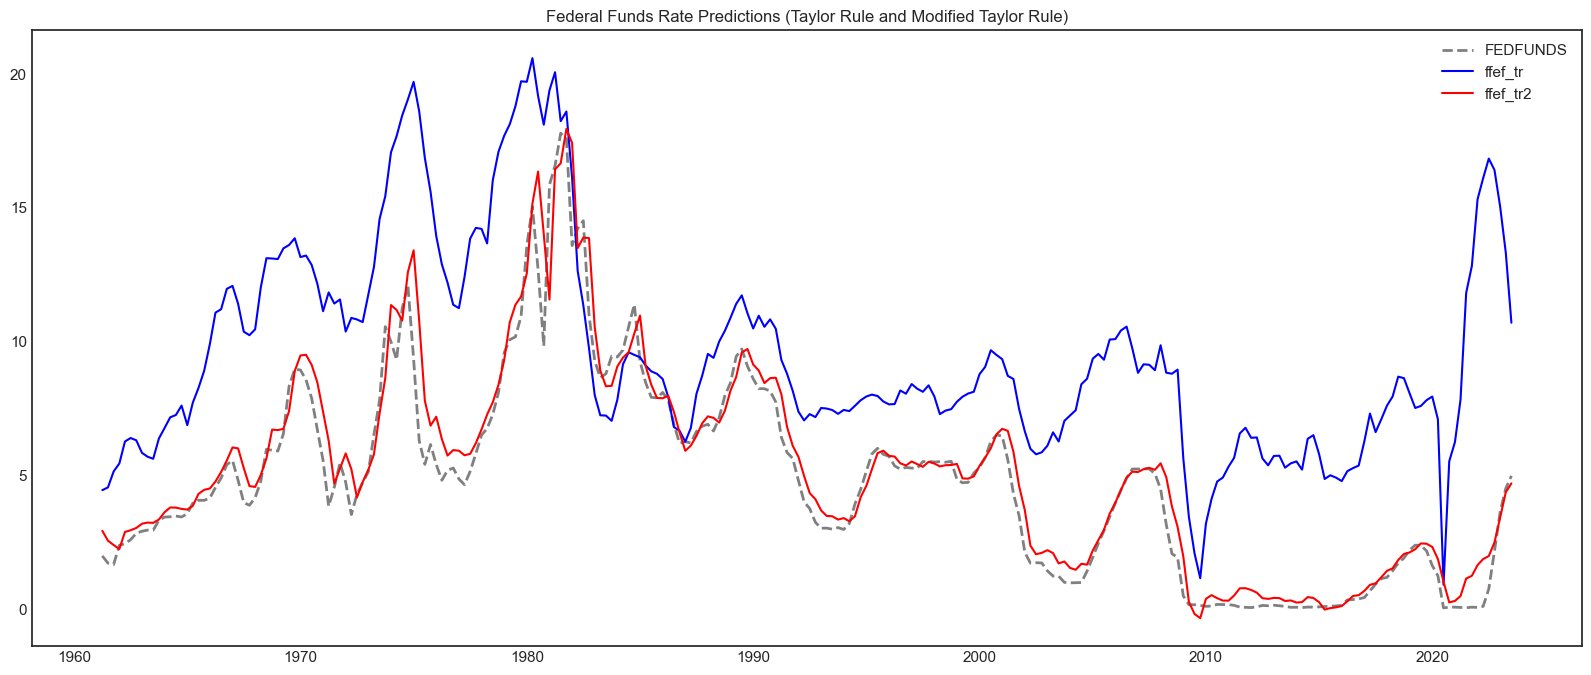

In [1143]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plo3
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['ffef_tr'], color='blue', linewidth=1.5)
ax.plot(taylor_df.index, taylor_df['ffef_tr2'], color='red', linewidth=1.5)

ax.legend(["FEDFUNDS", "ffef_tr","ffef_tr2"])
ax.set(title='Federal Funds Rate Predictions (Taylor Rule and Modified Taylor Rule)');

plt.show()

In [1144]:
#case = 1  # Taylor Rule
#scase = 2  # Modified Taylor Rule drop AR term
#case = 3  # Modified Taylor Rule
#case = 4  # Modified Taylor Rule
#case = 5  # Modified Taylor Rule drop inflation
case = 6  # Modified Taylor Rule drop inflation
#case = None  # Extened Taylor Rule

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    print('-- Taylor Rule')
    X_train = train_df[['gap_inf', 'gap_gdp']]
    y_train = train_df['FEDFUNDS']

    X_test = test_df[['gap_inf', 'gap_gdp',]]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_gdp']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 2:
    print('-- Taylor Rule')
    X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue',]]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_ue']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 3:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 4:
    print('-- Full Model (Lasso Base)')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag']]
    y_test = test_df['FEDFUNDS']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    rscaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #norm_num = Normalizer()
    #pt_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['FEDFUNDS-1','gap_inf', 'gap_gdp','gap_ue']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('rscaler_num',rscaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
                       
                       
elif case == 5:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
elif case == 6:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
elif case == 7:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    #numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
elif case == 8:
    print('-- Modified Taylor Rule')
    X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_diff']


    X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
else:
    print('-- Taylor Rule Extened')
    X_train = train_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','Real_Interest_Rate','CPIAUCSL_PC1','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

-- Taylor Rule Extened


In [1145]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (200, 4)


# Stats Model

In [1146]:
X_train_const = sm.add_constant(X_train_trf)

In [1147]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     716.2
Date:                Sat, 25 Nov 2023   Prob (F-statistic):          2.44e-115
Time:                        21:07:51   Log-Likelihood:                -254.18
No. Observations:                 200   AIC:                             518.4
Df Residuals:                     195   BIC:                             534.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.4118      0.135      3.043      0.003       0.145       0.679
num__gap_inf                                0.1349      0.033      4.149      0.000       0.071       0.199
num__gap_ue                                 0.1307      0.040      3.295      0.001       0.052       0.209
num__FEDFUNDS-1                             0.9230      0.028     33.226      0.000       0.868       0.978
cat__onehotencoder__recession_flag_True    -0.9575      0.198     -4.847      0.000      -1.347      -0.568
==============================================================================
Omnibus:                       48.765   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              673.862
Skew:                           0.357   Prob(JB):                    4.71e-147
Kurtosis:                      11.964   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1148]:
train_pred = ols_result.predict(X_train_const)

t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)

In [1149]:
model_stats_df = model_results('ols_train', y_train, train_pred_ols['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

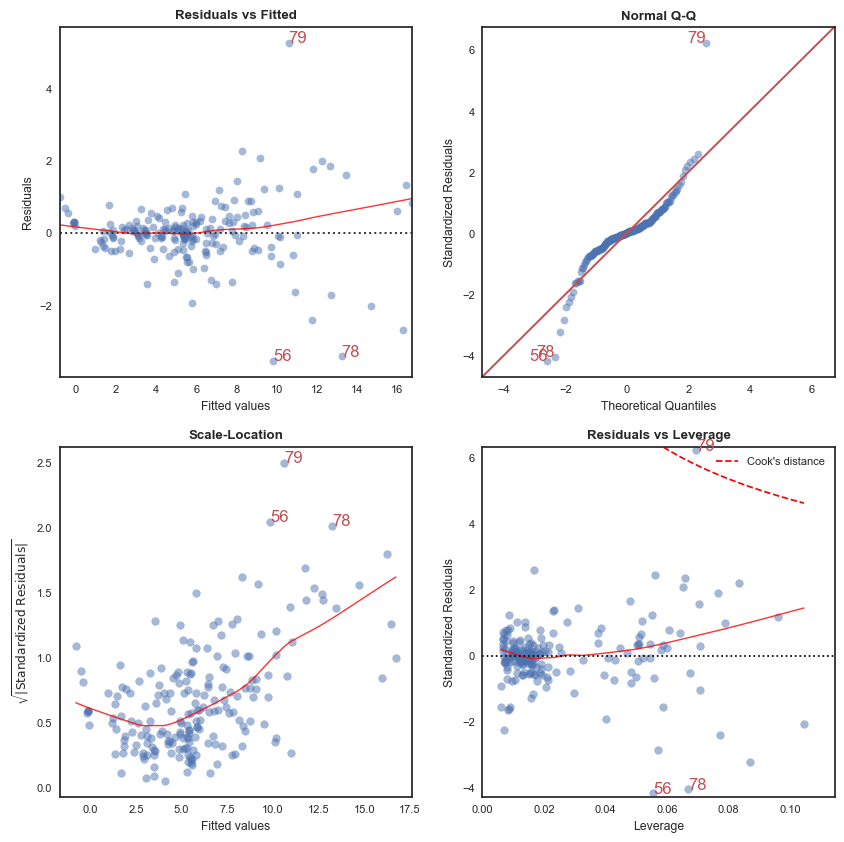

                                  Features  VIF Factor
0                                    const    4.800463
1                             num__gap_inf    2.337459
2                              num__gap_ue    1.026589
3                          num__FEDFUNDS-1    2.341544
4  cat__onehotencoder__recession_flag_True    1.194449


In [1150]:
cls = LinearRegDiagnostic(ols_result)
vif, fig, ax = cls()
print(vif)

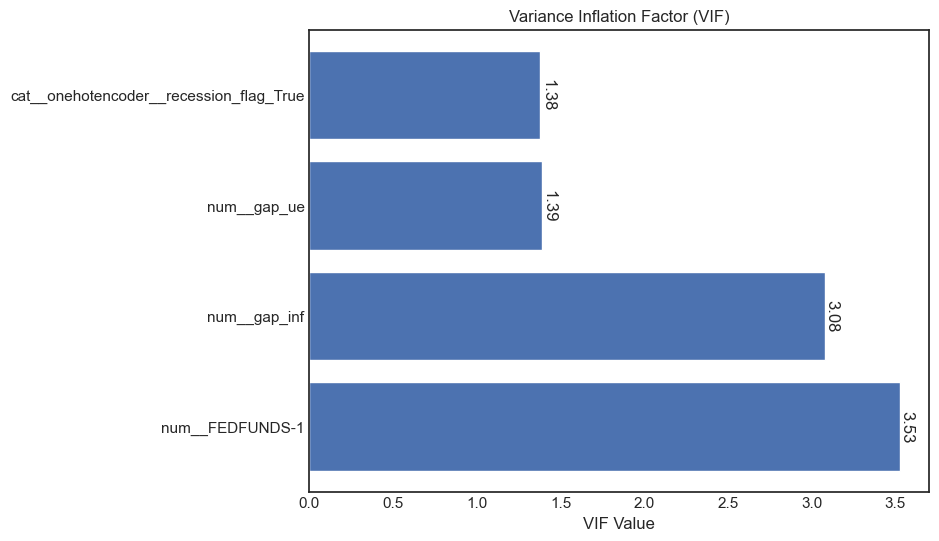

In [1151]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_trf.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_trf.values, i) for i in range(X_train_trf.shape[1])]


# Sort the VIF values for plotting
vif_data_sorted = vif_data.sort_values(by="VIF", ascending=False)

# Create a bar plot for VIF values
plt.figure(figsize=(8, 6))
plt.barh(vif_data_sorted['Variable'], vif_data_sorted['VIF'])

# Add vertical labels to the bars
for i, value in enumerate(vif_data_sorted['VIF']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)
    
plt.xlabel('VIF Value')
plt.title('Variance Inflation Factor (VIF)')
plt.show()

In [1152]:
# Get the residuals from the fitted model
residuals = ols_result.resid

# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8548307418823242
Shapiro-Wilk p-value: 0.0


In [1153]:
# White's Test: A significant p-value suggests the presence of heteroscedasticity.

white_test = het_white(ols_result.resid,  ols_result.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
wt_df = pd.DataFrame(zip(labels, white_test))
wt_df.columns = ['name', 'value']
round(wt_df,4)

,name,value
0,Test Statistic,88.8239
1,Test Statistic p-value,0.0000
2,F-Statistic,11.4311
3,F-Test p-value,0.0000


## Test

In [1154]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (50, 5)


In [1155]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(50, 6)

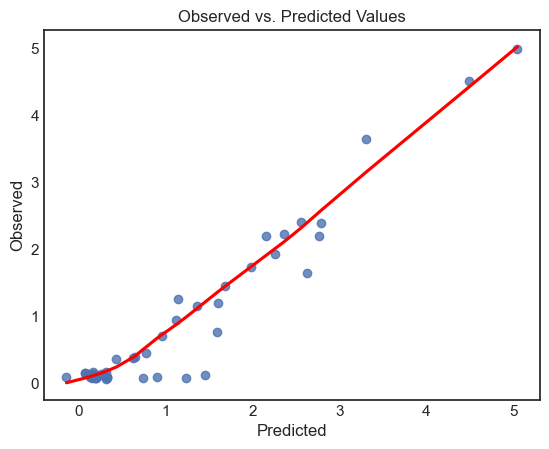

In [1156]:
fitted_vals = test_pred_ols['mean']
resids = y_test - test_pred_ols['mean']


fig, ax = plt.subplots(1)

sns.regplot(x=fitted_vals, y=y_test, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

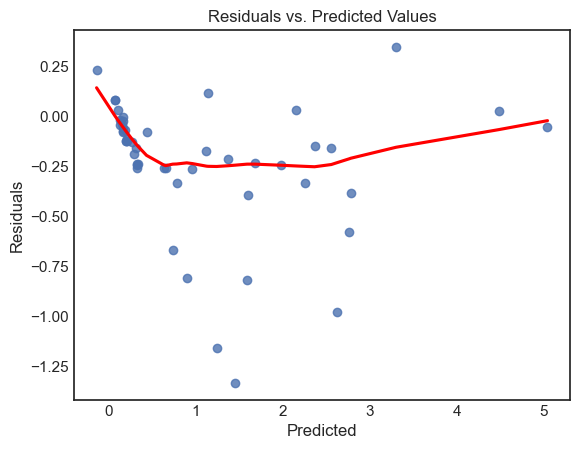

In [1157]:
fig, ax = plt.subplots(1)
sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

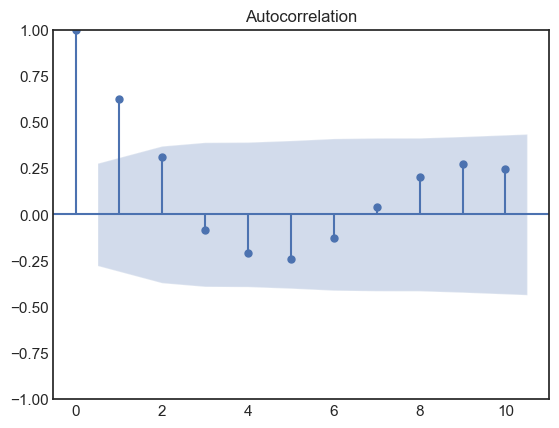

In [1158]:
acf = smt.graphics.plot_acf(resids, lags=10 , alpha=0.05)
acf.show()

In [1159]:
model_stats_df = model_results('ols_test', y_test, test_pred_ols['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )

# Generalized Linear Model

In [1160]:
X_train_const = sm.add_constant(X_train_trf)

In [1161]:
#glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.log()))
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Gaussian(link=sm.families.links.inverse_power()))

glm_result = glm_model.fit(attach_wls=True,atol=1e-10)

glm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  200
Model:                            GLM   Df Residuals:                      195
Model Family:                Gaussian   Df Model:                            4
Link Function:          inverse_power   Scale:                          3.6594
Method:                          IRLS   Log-Likelihood:                -411.02
Date:                Sat, 25 Nov 2023   Deviance:                       713.58
Time:                        21:07:52   Pearson chi2:                     714.
No. Iterations:                    16   Pseudo R-squ. (CS):             0.8908
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.2424      0.007     34.545      0.000       0.229       0.256
num__gap_inf                               -0.0039      0.001     -4.297      0.000      -0.006      -0.002
num__gap_ue                                -0.0073      0.002     -2.937      0.003      -0.012      -0.002
num__FEDFUNDS-1                            -0.0107      0.001    -12.667      0.000      -0.012      -0.009
cat__onehotencoder__recession_flag_True     0.0158      0.005      3.417      0.001       0.007       0.025
===========================================================================================================
"""

infl = glm_result.get_influence(observed=False)

summ_df = infl.summary_frame()
#summ_df.sort_values("cooks_d", ascending=False)[:10]

fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

plt.show()

In [1162]:
train_pred_glm = glm_result.predict(X_train_const)

t = glm_result.get_prediction(X_train_const)
train_pred_glm = t.summary_frame(alpha=0.05)

In [1163]:
model_stats_df = model_results('glm_train', y_train, train_pred_glm['mean'], X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [1164]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

X_test_const = sm.add_constant(X_test_trf)
print('X_test_const: ', X_test_const.shape)

X_test_const:  (50, 5)


In [1165]:
t = glm_result.get_prediction(X_test_const)
test_pred_glm = t.summary_frame(alpha=0.05)
test_pred_glm.shape

(50, 4)

In [1166]:
model_stats_df = model_results('glm_test', y_test, test_pred_glm['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,-1.1459,-1.1568,25.0445,5.0044
1,ffef_tr_test,-40.4673,-41.3312,56.7392,7.5325
2,ffef_tr2_train,0.9079,0.9074,1.0753,1.0369
3,ffef_tr2_test,0.7806,0.7760,0.3002,0.5479
4,Naive_train,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,ols_train,0.9363,0.9353,0.7438,0.8624
7,ols_test,0.8862,0.8788,0.1557,0.3946
8,glm_train,0.6943,0.6896,3.5679,1.8889
9,glm_test,-7.9848,-8.5707,12.2937,3.5062


# Lasso

In [1167]:
# Lasso with 5 fold cross-validation
model = linear_model.LassoCV(cv=5, random_state=rand_int, max_iter=10000)

# Fit model
model.fit(X_train_trf, y_train)

print('model.alpha_: ', model.alpha_)

model.alpha_:  0.016961235449298673


In [1168]:
pipe_lasso = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',linear_model.LassoCV(cv=5, 
                                                                           #alphas=[0.001, 0.01,0.05, 0.1, 0.5],
                                                                           random_state=rand_int, 
                                                                           max_iter=10000))]
)

param_lasso = {
    #'model__alpha': [0.01, 0.05, 0.1, 0.5],
    'model__verbose': [0],
}


cv = RandomizedSearchCV(estimator = pipe_lasso, 
                        param_distributions = param_lasso,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('Lasso', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

Lasso ) Best Accuracy Score: 0.8593116406040732 Parameters: {} {'model__verbose': 0}


In [1169]:
model = cv.best_estimator_.named_steps.model

In [1170]:
lasso_best = linear_model.Lasso(alpha=model.alpha_)
lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [1171]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,coef
num__FEDFUNDS-1,0.918207
cat__onehotencoder__recession_flag_True,-0.774202
num__gap_inf,0.128271
num__gap_ue,0.121446


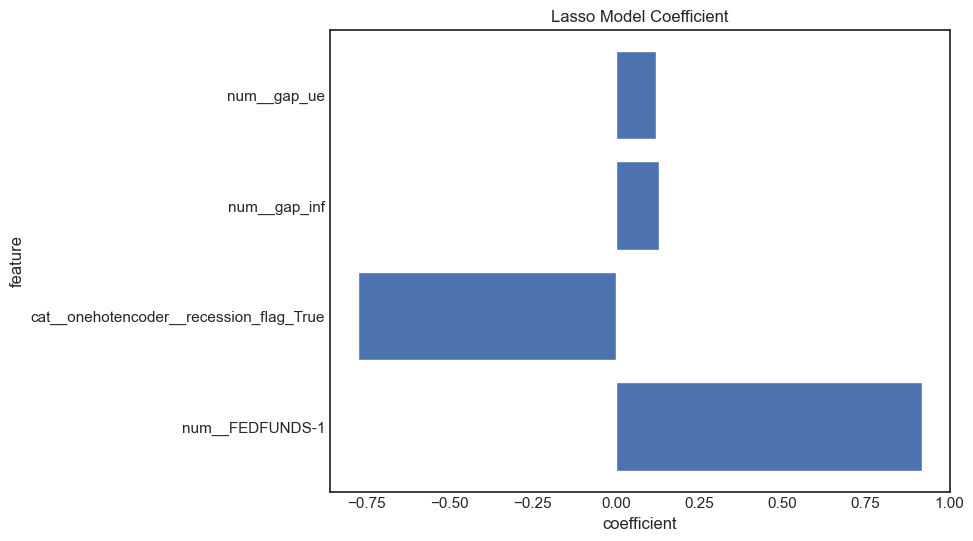

In [1172]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

In [1173]:
model_stats_df = model_results('lasso_train', y_train, train_pred_lasso, X_train.shape[0], X_train.shape[1] , model_stats_df )

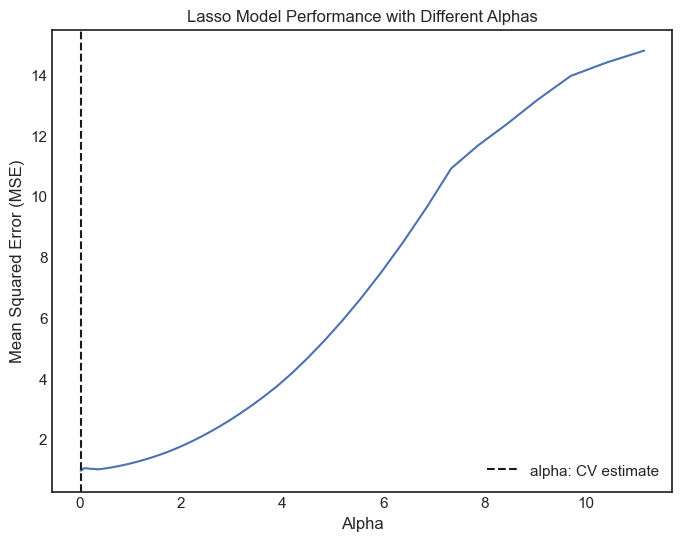

In [1174]:
mse_values = np.mean(model.mse_path_, axis=1)

# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.plot(model.alphas_, mse_values)

plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lasso Model Performance with Different Alphas')
plt.grid(False)
plt.show()

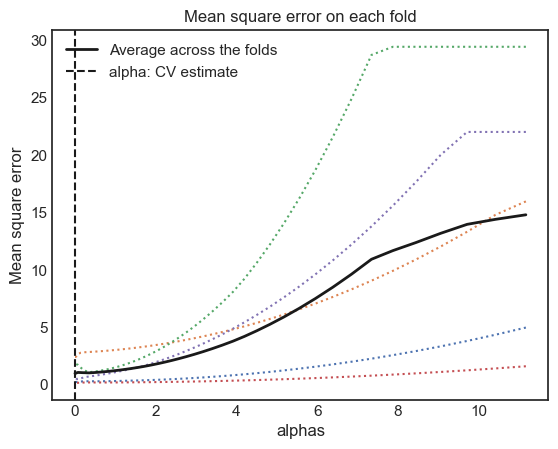

In [1175]:
#plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
plt.show()
#ymin, ymax = 50000, 250000
#plt.ylim(ymin, ymax);

In [1176]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (50,)


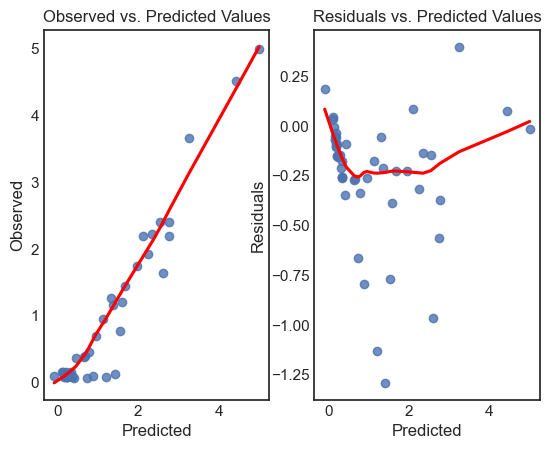

In [1177]:
fitted_vals = test_pred_lasso
resids = y_test - test_pred_lasso


fig, ax = plt.subplots(1,2)

sns.regplot(x=fitted_vals, y=y_test, lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=12)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=12)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

plt.show()

In [1178]:
durbin_watson_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_stat)

Durbin-Watson statistic: 1.7312975465535514


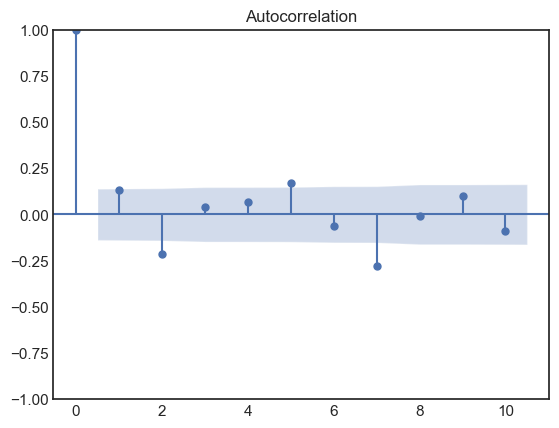

In [1179]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [1180]:
model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

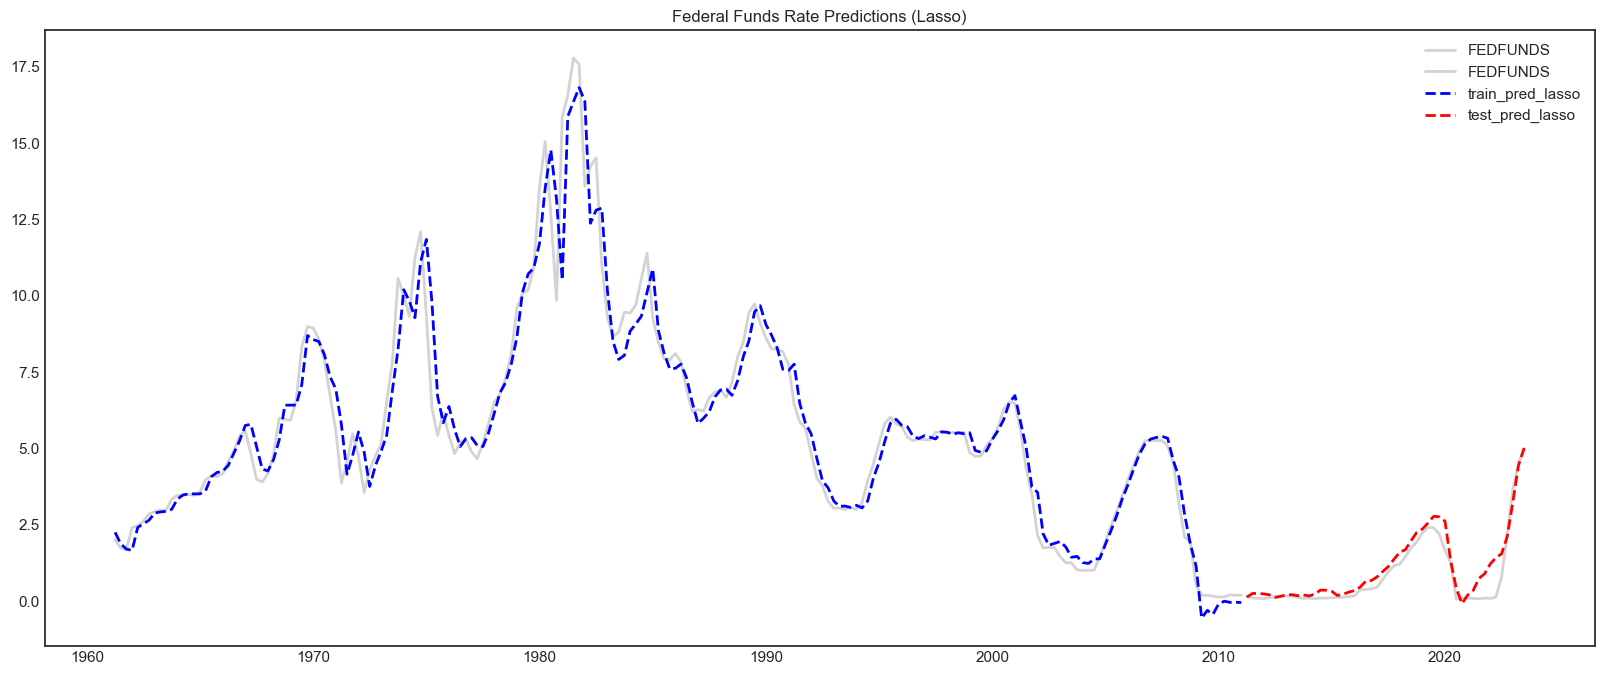

In [1181]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

# LGBM

In [1182]:
pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)

param_ltb = {
    'model__n_estimators': randint(100, 300), #[100, 200, 300],
    'model__learning_rate': uniform(0.01, 0.5),  #[0.01, 0.05, 0.1, 0.5],
    'model__max_depth': randint(3, 10),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
    'model__eval_metric': ['r2_score'],
}


cv = RandomizedSearchCV(estimator = pipe_ltb, 
                        param_distributions = param_ltb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('LGBMR', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

LGBMR ) Best Accuracy Score: 0.5824814609079889 Parameters: {} {'model__eval_metric': 'r2_score', 'model__learning_rate': 0.020404898976033085, 'model__max_depth': 4, 'model__min_data_in_leaf': 10, 'model__n_estimators': 260, 'model__num_leaves': 49, 'model__reg_alpha': 0.07714526452120027, 'model__verbose': -1}


In [1183]:
cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp_num',
                                                                   SimpleImputer())]),
                                                  ['gap_inf', 'gap_ue',
                                                   'FEDFUNDS-1']),
                                                 ('cat',
                                                  Pipeline(steps=[('transformer',
                                                                   ColumnTransformer(transformers=[('onehotencoder',
                                                                                                    OneHotEncoder(categories=[[False,
                                                                                                                               True]],
                                                                                                                  drop='first',
                                                                                                                  handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['recession_flag'])]))]),
                                                  ['recession_flag'])])),
                ('model',
                 LGBMRegressor(eval_metric='r2_score',
                               learning_rate=0.020404898976033085, max_depth=4,
                               min_data_in_leaf=10, n_estimators=260,
                               num_leaves=49, reg_alpha=0.07714526452120027,
                               verbose=-1))])

In [1184]:
cv.best_estimator_.named_steps.model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [1185]:
train_pred_lgbm = cv.best_estimator_.predict(X_train, pred_contrib=False, raw_score=False)

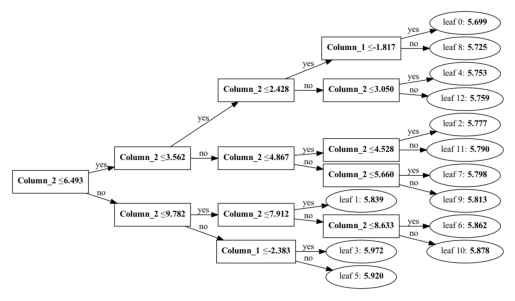

In [1186]:
ltb.plot_tree(cv.best_estimator_.named_steps.model)
plt.show()

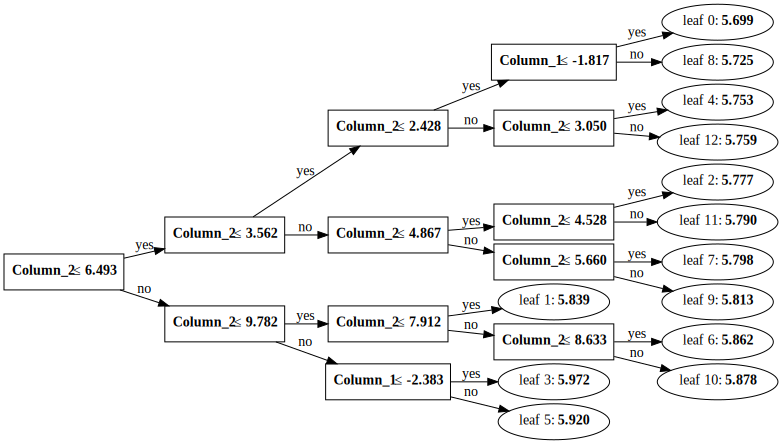

In [1187]:
ltb.create_tree_digraph(cv.best_estimator_.named_steps.model)

In [1188]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.named_steps.preprocessor.get_feature_names_out(),
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})
feature_df.sort_values(by=['feature_importance'], key=pd.Series.abs , ascending=False , inplace=True)
feature_df

,feature_name,feature_importance
2,num__FEDFUNDS-1,1105
1,num__gap_ue,688
0,num__gap_inf,426
3,cat__onehotencoder__recession_flag_True,64


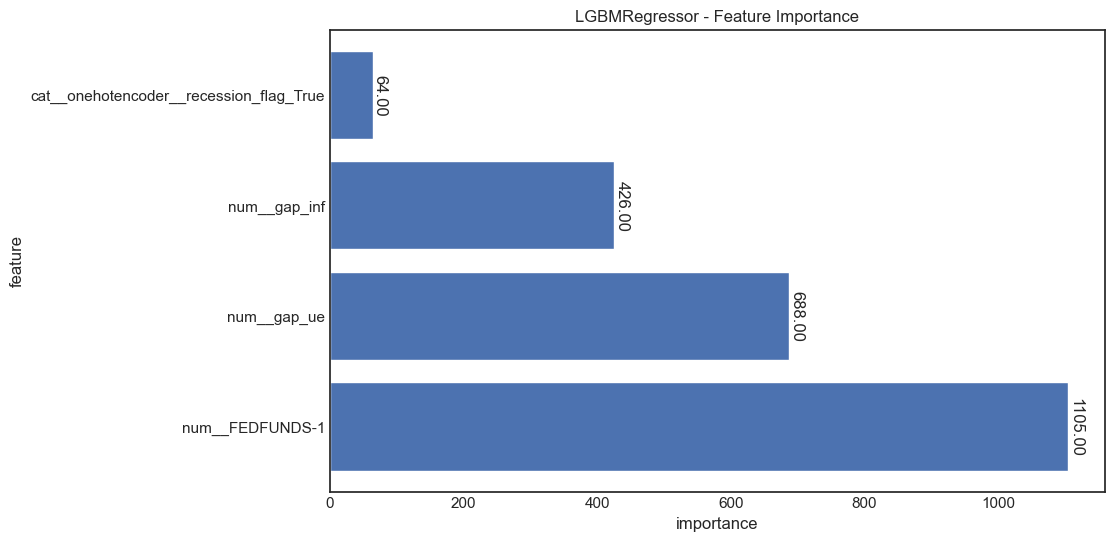

In [1189]:
plt.figure(figsize=(10, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.2f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('LGBMRegressor - Feature Importance')
plt.grid(False)
plt.show()

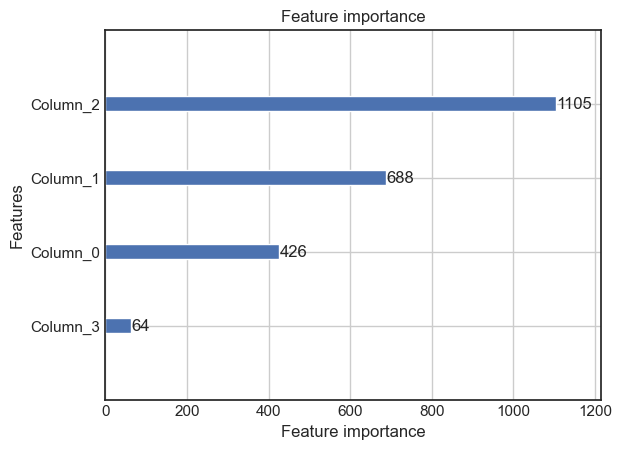

In [1190]:
ltb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [1191]:
model_stats_df = model_results('lgbm_train', y_train, train_pred_lgbm, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [1192]:
test_pred_lgbm = cv.best_estimator_.predict(X_test, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(50,)

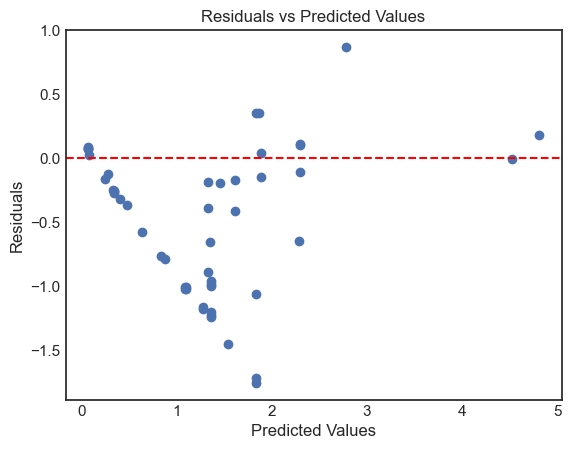

In [1193]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_lgbm, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [1194]:
model_stats_df = model_results('lgbm_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

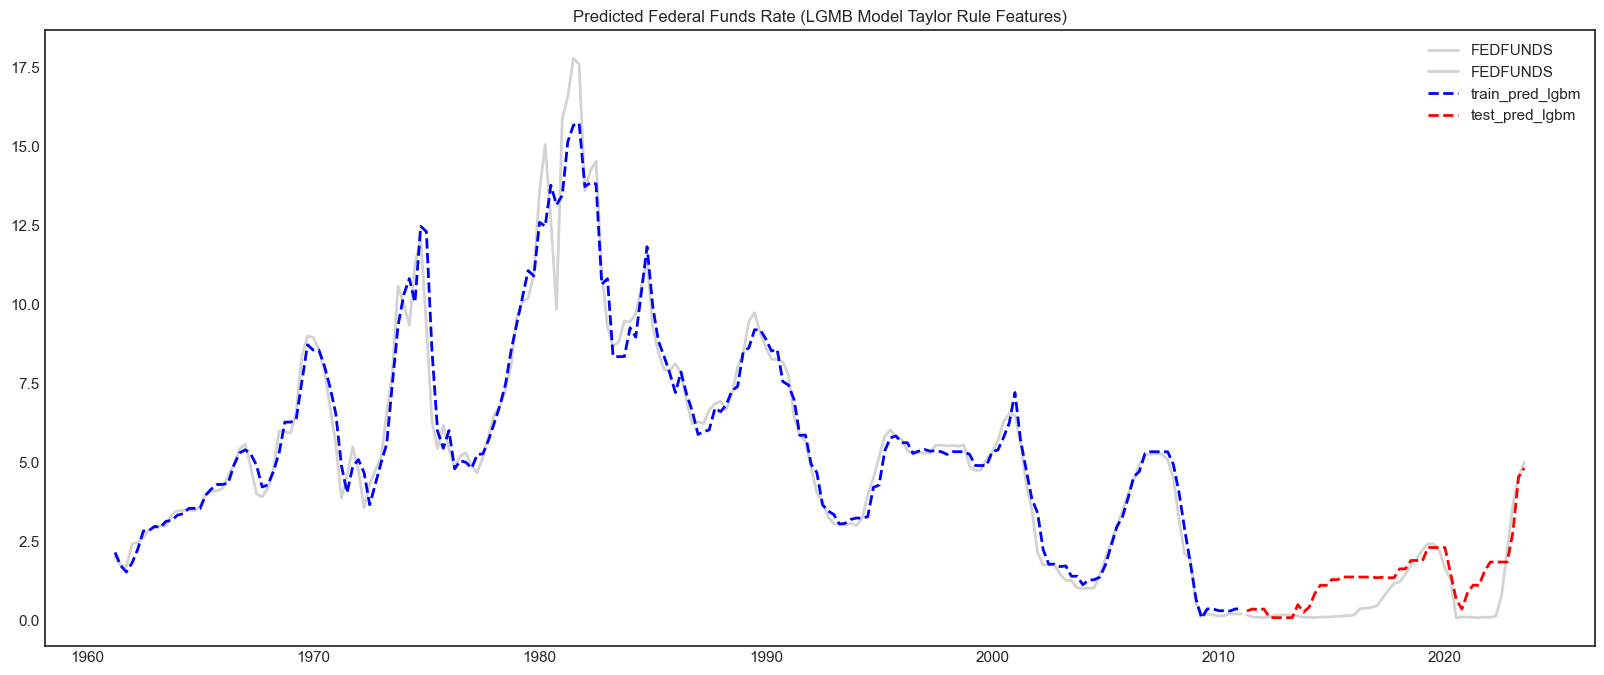

In [1195]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Predicted Federal Funds Rate (LGMB Model Taylor Rule Features)');
plt.show()

# Sharpe

In [1196]:
model = cv.best_estimator_.named_steps.model
model

LGBMRegressor(eval_metric='r2_score', learning_rate=0.020404898976033085,
              max_depth=4, min_data_in_leaf=10, n_estimators=260, num_leaves=49,
              reg_alpha=0.07714526452120027, verbose=-1)

In [1197]:
explainer = None
shap_values = None

In [1198]:
try:
    explainer = shap.Explainer(model, X_test_trf)
    shap_values = explainer(X_test_trf, check_additivity=False)
except Exception as e:
    print('-- error ')
    print(e)

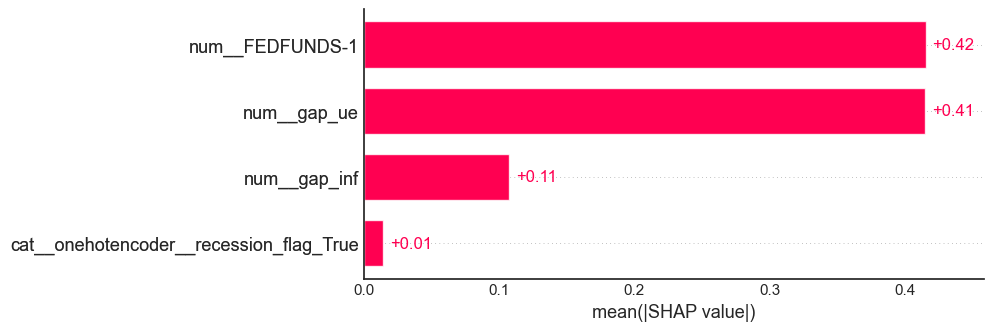

In [1199]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

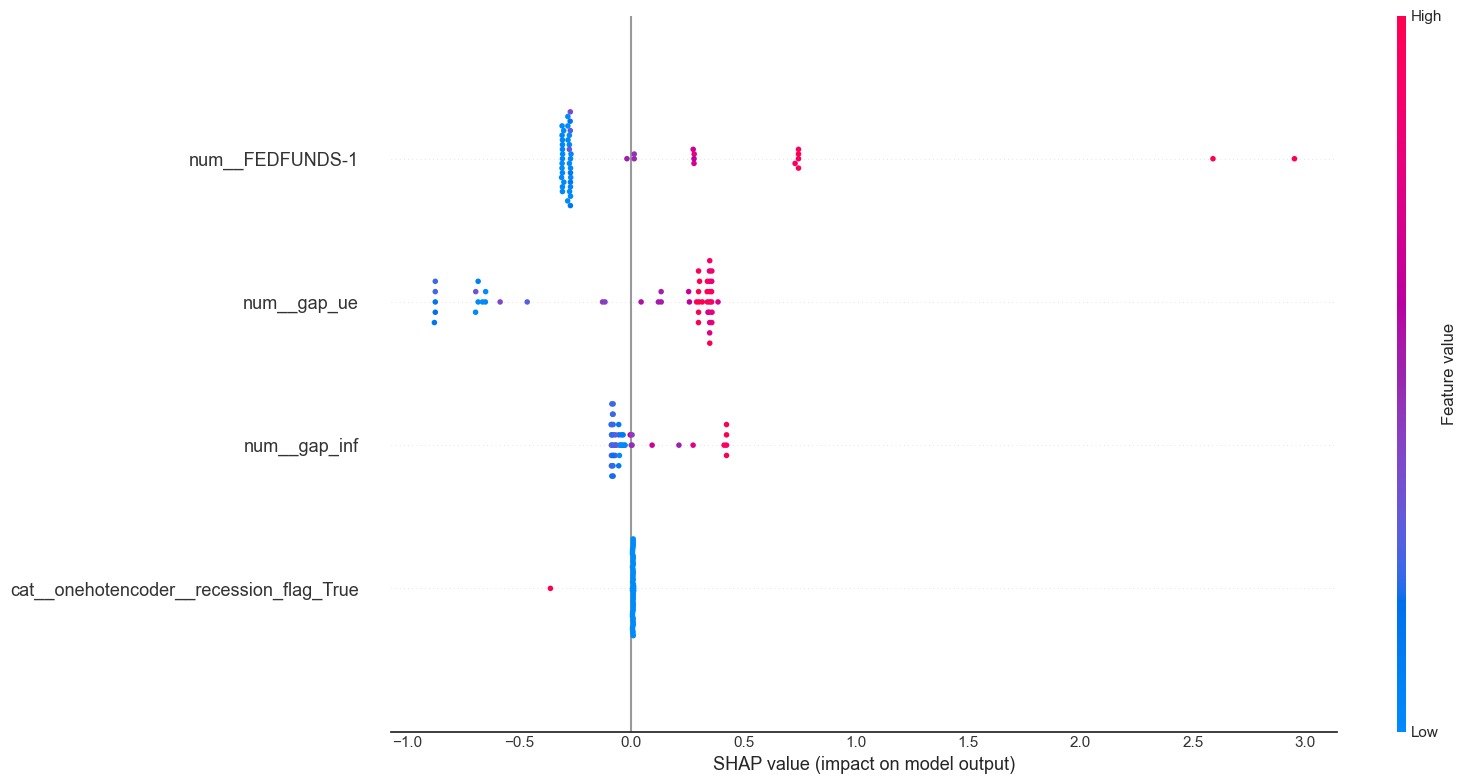

In [1200]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(16,8))

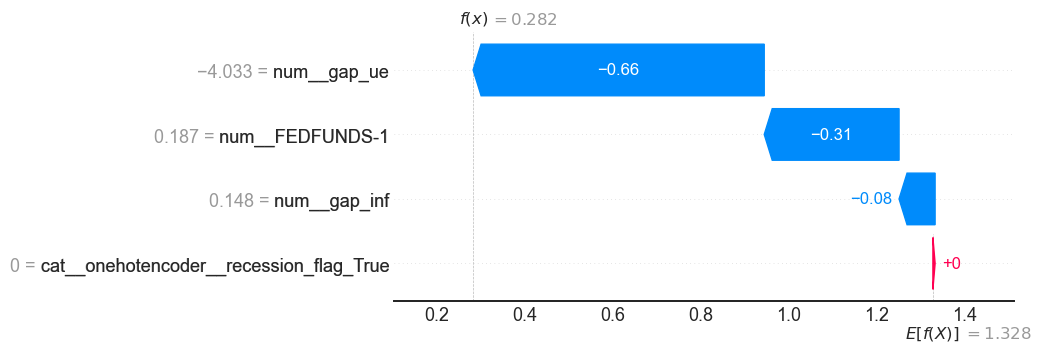

In [1201]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


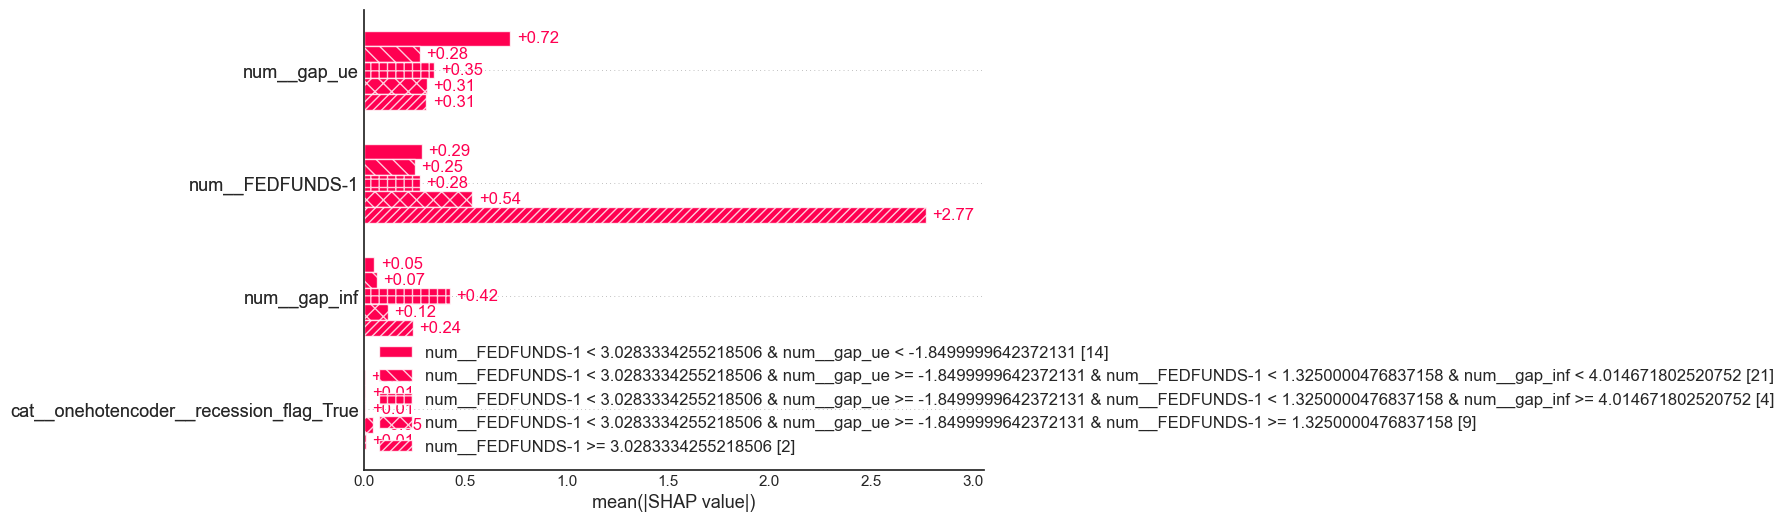

In [1202]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [1203]:
shap_values.shape

(50, 4)

In [1204]:
shap.force_plot(shap_values[5], plot_cmap = "PkYg")

In [1205]:
explainer_tmp = None
shap_values_tmp = None

try:
    explainer_tmp = shap.Explainer(model)
    shap_values_tmp = explainer_tmp.shap_values(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

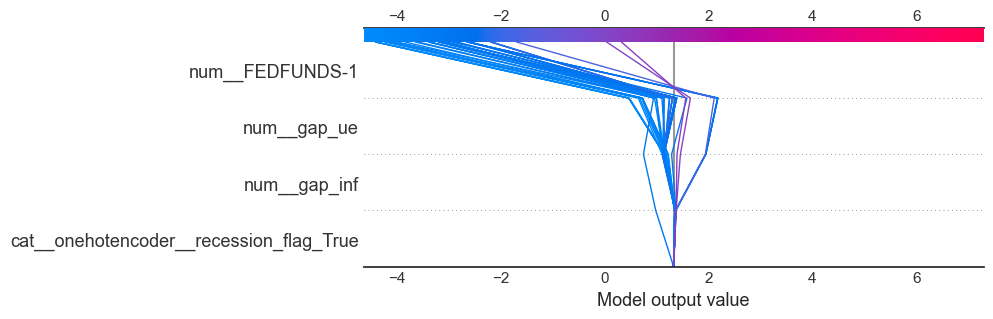

In [1206]:
if (shap_values_tmp is not None):
    expected_value = explainer.expected_value
    shap.decision_plot(expected_value, shap_values_tmp, feature_names, ignore_warnings=True)

In [1207]:
expected_value

1.3281329340192705

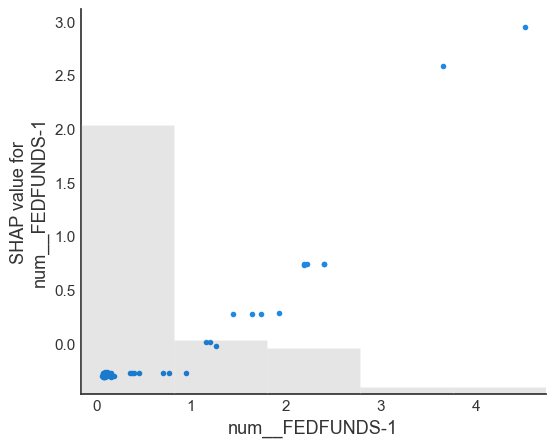

In [1208]:
if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__FEDFUNDS-1"])

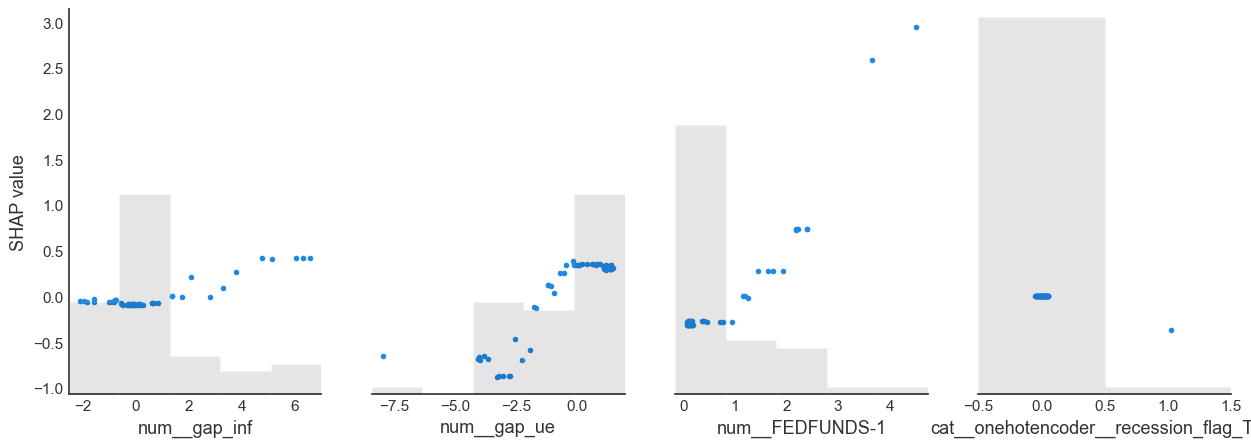

In [1209]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)

# XGB

In [1210]:
pipe_xgb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',xgb.XGBRegressor())]
)

param_xgb = {
    'model__learning_rate': uniform(0.01, 0.5),
    'model__n_estimators': randint(100, 300),
    'model__max_depth': randint(3, 10),
    'model__min_child_weight' : randint(1, 15),
    'model__subsample' : uniform(0.05, 1.0),
    'model__colsample_bytree' : uniform(0.05, 1.0),
    'model__reg_alpha' : uniform(0.01, 0.1), 
    'model__verbose': [-1],
}


cv = RandomizedSearchCV(estimator = pipe_xgb, 
                        param_distributions = param_xgb,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('XGB', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

XGB ) Best Accuracy Score: 0.3621130682900535 Parameters: {} {'model__colsample_bytree': 0.7758614974313065, 'model__learning_rate': 0.017249308005608803, 'model__max_depth': 9, 'model__min_child_weight': 5, 'model__n_estimators': 170, 'model__reg_alpha': 0.060069680454765316, 'model__subsample': 0.8547895388034705, 'model__verbose': -1}


In [1211]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.964334633381056

In [1212]:
cv.best_estimator_.named_steps.model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7758614974313065, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.017249308005608803, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=170, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1213]:
train_pred_xgb = cv.best_estimator_.predict(X_train)

In [1214]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(cv.best_estimator_.named_steps.model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

plt.show()

In [1215]:
cv

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imp_num',
                                                                                                SimpleImputer())]),
                                                                               ['gap_inf',
                                                                                'gap_ue',
                                                                                'FEDFUNDS-1']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('transformer',
                                                                                                ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                 OneHotEncoder(categories=[[False,
                                                                                                                                                            True]],
                                                                                                                                               drop='first',
                                                                                                                                               handle_unknown='ignore',
                                                                                                                                               spars...
                                        'model__min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16be52f20>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16bd7fc10>,
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16bb6f1f0>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16bbb7b50>,
                                        'model__verbose': [-1]},
                   random_state=12, scoring='r2')

In [1216]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

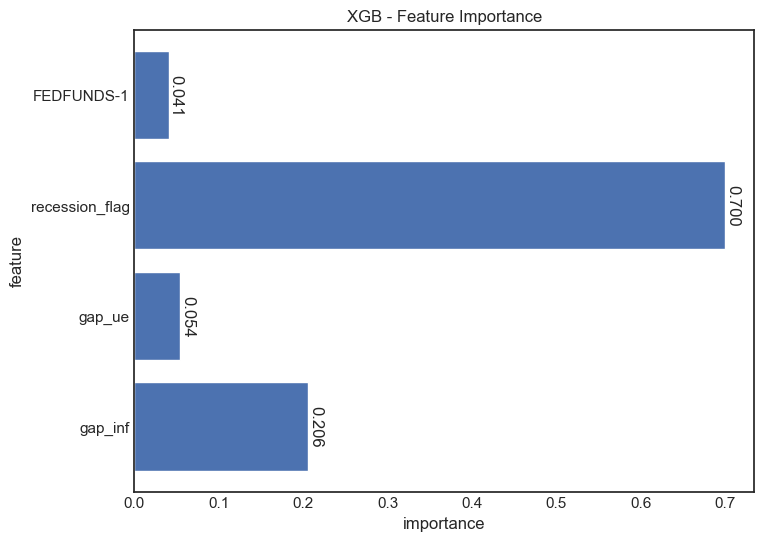

In [1217]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.3f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('XGB - Feature Importance')
plt.grid(False)
plt.show()

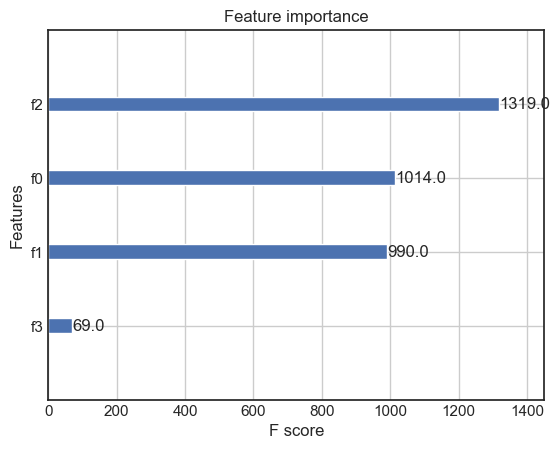

In [1218]:
xgb.plot_importance(cv.best_estimator_.named_steps.model)
plt.show()

In [1219]:
model_stats_df = model_results('xgb_train', y_train, train_pred_xgb, X_train.shape[0], X_train.shape[1] , model_stats_df )

## Test

In [1220]:
test_pred_xgb = cv.best_estimator_.predict(X_test)
print('test_pred_xbg: ', test_pred_xgb.shape)

test_pred_xbg:  (50,)


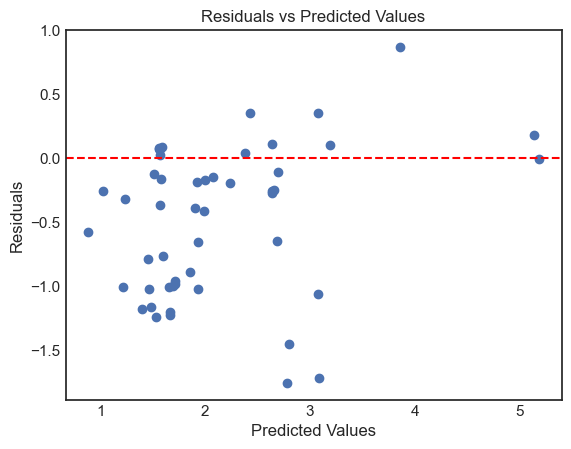

In [1221]:
residuals = y_test - test_pred_lgbm
plt.scatter(test_pred_xgb, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0 for reference
plt.show()

In [1222]:
model_stats_df = model_results('xgb_test', y_test, test_pred_lgbm, X_test.shape[0], X_test.shape[1] , model_stats_df )

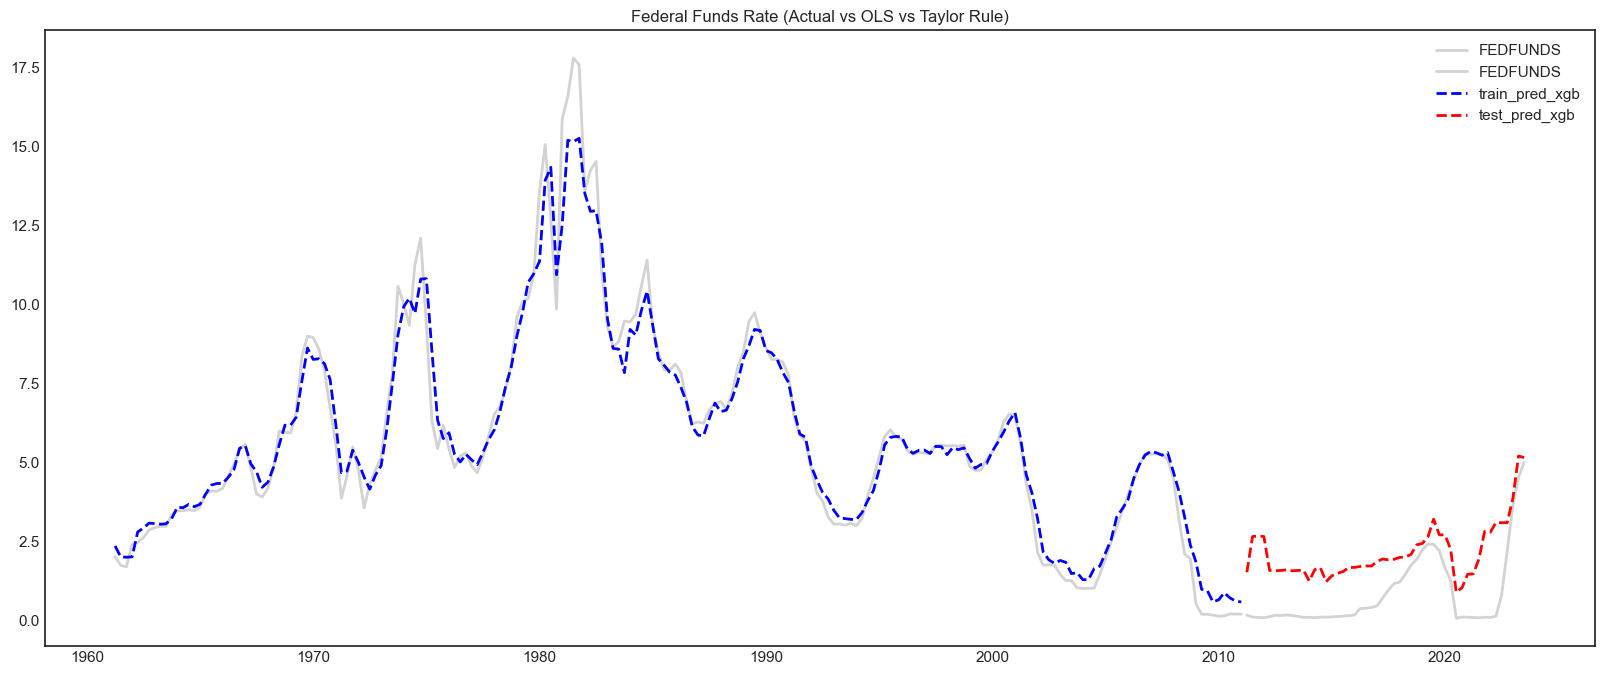

In [1223]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_xgb","test_pred_xgb"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');
plt.show()

# AdaBoostRegressor

In [1224]:
pipe_ada = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)

param_ada = {
    'model__learning_rate' : [0.01, 0.1, 0.5, 1.0],
    'model__n_estimators' : [50, 100, 150, 200, 250],
    'model__loss' : ["linear","exponential"],  
}


cv = RandomizedSearchCV(estimator = pipe_ada, 
                        param_distributions = param_ada,
                        random_state=rand_int, 
                        scoring="r2")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('ADA', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

ADA ) Best Accuracy Score: 0.3829663924575345 Parameters: {} {'model__n_estimators': 250, 'model__loss': 'exponential', 'model__learning_rate': 0.01}


In [1225]:
cv.best_estimator_.named_steps.model.score(X_train_trf, y_train)

0.9453545250178003

In [1226]:
cv.best_estimator_.named_steps.model

AdaBoostRegressor(learning_rate=0.01, loss='exponential', n_estimators=250)

In [1227]:
feature_df = pd.DataFrame({'feature_name': cv.best_estimator_.feature_names_in_,
                           'feature_importance': cv.best_estimator_.named_steps.model.feature_importances_})

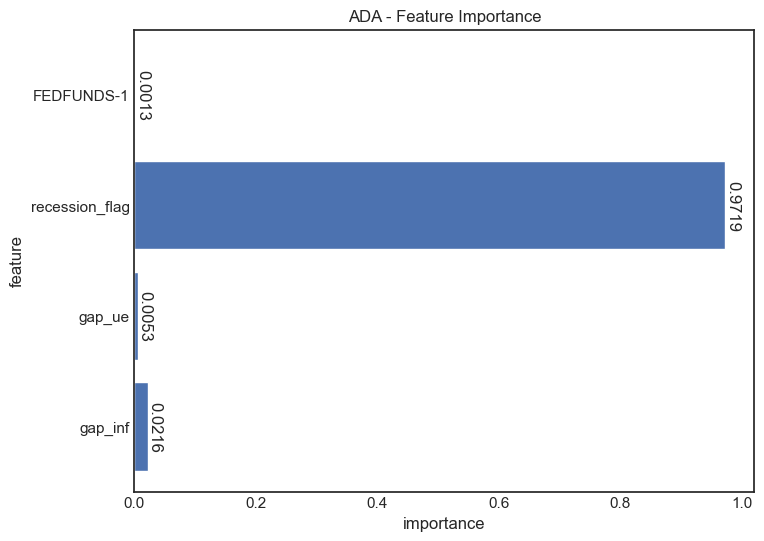

In [1228]:
plt.figure(figsize=(8, 6))

bars = plt.barh(feature_df['feature_name'], feature_df['feature_importance'])
    
# Add vertical labels to the bars
for i, value in enumerate(feature_df['feature_importance']):
    plt.text(value, i, f'{value:.4f}', va='center', ha='left', rotation=-90)

    
plt.xlabel('importance')
plt.ylabel('feature')
plt.title('ADA - Feature Importance')
plt.grid(False)
plt.show()

In [1229]:
train_pred_ada = cv.best_estimator_.predict(X_train)
model_stats_df = model_results('ada_test', y_train, train_pred_ada, X_train.shape[0], X_train.shape[1] , model_stats_df )

In [1230]:
test_pred_ada = cv.best_estimator_.predict(X_test)
model_stats_df = model_results('ada_test', y_test, test_pred_ada, X_test.shape[0], X_test.shape[1] , model_stats_df )

# tsa.SARIMAX

In [1231]:
sarimax_model = sm.tsa.SARIMAX(y_train, order=(1,0,0), exog=X_train_trf).fit(disp=False)
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  200
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -257.351
Date:                Sat, 25 Nov 2023   AIC                            526.702
Time:                        21:08:15   BIC                            546.492
Sample:                    03-31-1961   HQIC                           534.711
                         - 12-31-2010                                         
Covariance Type:                  opg                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
num__gap_inf                                0.1063      0.029      3.666      0.000       0.049       0.163
num__gap_ue                                 0.1056      0.063      1.684      0.092      -0.017       0.228
num__FEDFUNDS-1                             0.9817      0.026     37.353      0.000       0.930       1.033
cat__onehotencoder__recession_flag_True    -0.9407      0.200     -4.714      0.000      -1.332      -0.550
ar.L1                                       0.1254      0.060      2.088      0.037       0.008       0.243
sigma2                                      0.7676      0.040     19.269      0.000       0.690       0.846
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1079.81
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [1232]:
train_result = sarimax_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [1233]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-03-31,2.012242,0.883113,0.281372,3.743113
1961-06-30,1.635094,0.883113,-0.095777,3.365964
1961-09-30,1.430560,0.883113,-0.300311,3.161430
1961-12-31,1.388106,0.883113,-0.342765,3.118976
1962-03-31,2.171495,0.883113,0.440625,3.902365
...,...,...,...,...
2009-12-31,-0.419998,0.883113,-2.150869,1.310872
2010-03-31,-0.354908,0.883113,-2.085779,1.375962
2010-06-30,-0.381914,0.883113,-2.112785,1.348956
2010-09-30,-0.366482,0.883113,-2.097352,1.364389


## Test

In [1234]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = sarimax_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [1235]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

predict_ci = test_result.conf_int(alpha=0.5)
print('predict_ci: ',predict_ci.shape)

predict_ci:  (50, 2)


In [1236]:
residuals = y_test - test_pred_SARIM['mean']

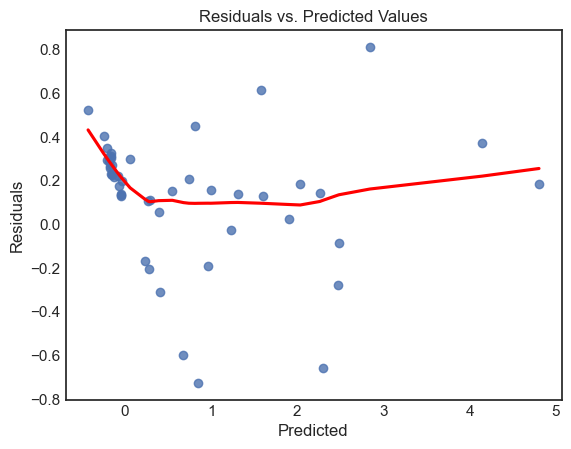

In [1237]:
fig, ax = plt.subplots(1)
sns.regplot(x=test_pred_SARIM['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

In [1238]:
# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,6))

Shapiro-Wilk Test Statistic: 0.8886105418205261
Shapiro-Wilk p-value: 0.000206


In [1239]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#p-value of less 0.05 indicates as significant amount of autocorrelations amoung the residual

# Perform Ljung-Box test for autocorrelation in residuals
lags = 10  # Number of lags to consider, can be adjusted
lb_df = acorr_ljungbox(residuals, lags=lags)
round(lb_df,4)

,lb_stat,lb_pvalue
1,13.5824,0.0002
2,16.7135,0.0002
3,18.0915,0.0004
4,20.7324,0.0004
5,23.0201,0.0003
6,23.1684,0.0007
7,24.6647,0.0009
8,29.7050,0.0002
9,34.9020,0.0001
10,38.1804,0.0000


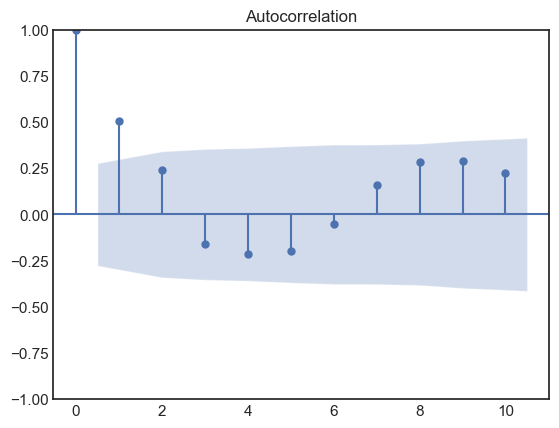

In [1240]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [1241]:
residuals.values

array([ 0.31316582,  0.21687395,  0.23040422,  0.23188742,  0.28791705,
        0.40157773,  0.34658889,  0.32511488,  0.30242737,  0.30560373,
        0.25706532,  0.29322963,  0.22478003,  0.13947811,  0.13319244,
        0.17436993,  0.29283394,  0.26985842,  0.2219669 ,  0.19940958,
        0.29955455,  0.10752484,  0.10921975,  0.05649517,  0.1500482 ,
        0.20756079,  0.15626296, -0.02828427,  0.13691171,  0.13087916,
        0.02346924,  0.18601743,  0.14253466, -0.08685383, -0.28017622,
       -0.65946444,  0.44722493, -0.16885616,  0.52081785,  0.26739313,
        0.12830123, -0.20518075, -0.31179053, -0.59950538, -0.72557725,
       -0.19259241,  0.61443516,  0.8118307 ,  0.37067753,  0.18582841])

In [1242]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    



def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


In [1243]:
adf_test(taylor_df["FEDFUNDS"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.108420
p-value                          0.241142
#Lags Used                       7.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


p-value < 0.05 - stationary

Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, the series is non-stationary.

In [1244]:
kpss_test(taylor_df["FEDFUNDS"])

Results of KPSS Test:
Test Statistic            1.090355
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


p-value > 0.05 - stationary

Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test

<Axes: xlabel='DATE'>

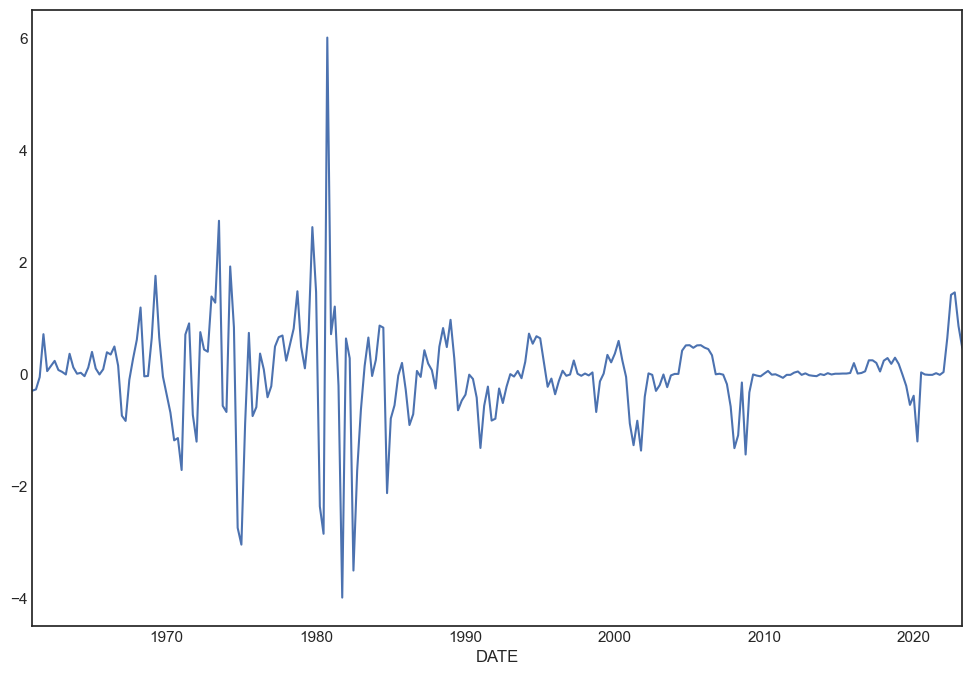

In [1245]:
taylor_df["FEDFUNDS_diff"] = taylor_df["FEDFUNDS"] - taylor_df["FEDFUNDS-1"]
taylor_df["FEDFUNDS_diff"].dropna().plot(figsize=(12, 8))

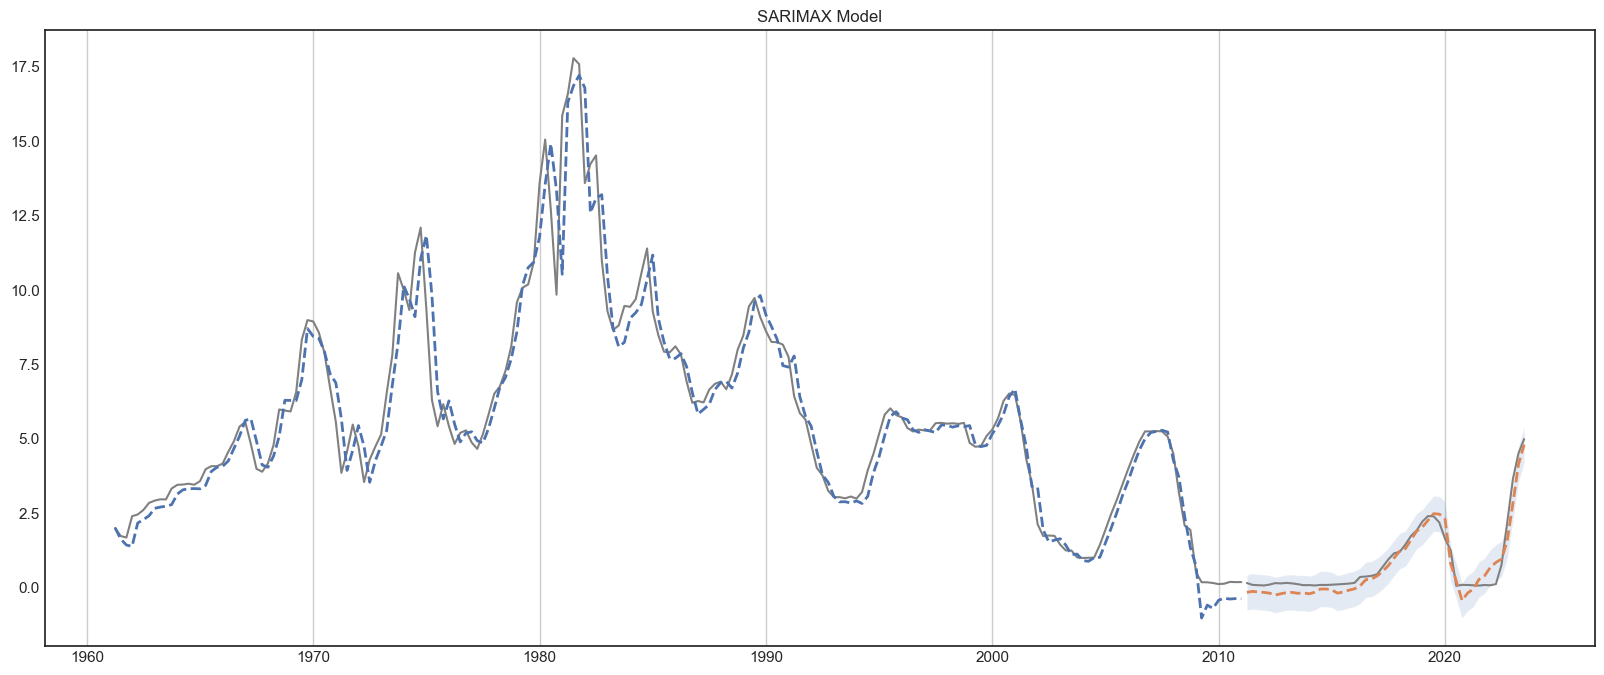

In [1246]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

plt.show()

In [1247]:
model_stats_df = model_results('SARIMAX_train',train_df['FEDFUNDS'], train_pred_SARIM['mean'], X_train.shape[0], X_train.shape[1], model_stats_df )
model_stats_df = model_results('SARIMAX_test', test_df['FEDFUNDS'], test_pred_SARIM['mean'], X_test.shape[0], X_test.shape[1] , model_stats_df )
model_stats_df

,name,r_sq,adj_r_sq,mse,rmse
0,ffef_tr_train,-1.1459,-1.1568,25.0445,5.0044
1,ffef_tr_test,-40.4673,-41.3312,56.7392,7.5325
2,ffef_tr2_train,0.9079,0.9074,1.0753,1.0369
3,ffef_tr2_test,0.7806,0.7760,0.3002,0.5479
4,Naive_train,0.9206,0.9206,0.9263,0.9624
5,Naive_test,0.8830,0.8830,0.1601,0.4002
6,ols_train,0.9363,0.9353,0.7438,0.8624
7,ols_test,0.8862,0.8788,0.1557,0.3946
8,glm_train,0.6943,0.6896,3.5679,1.8889
9,glm_test,-7.9848,-8.5707,12.2937,3.5062
